# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [3]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler 

In [4]:
### TODO: Write data loaders for training, validation, and test sets
data_dir = 'landmark_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# transform
data_transform = transforms.Compose([transforms.RandomResizedCrop(256), 
                                      transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train)) 
np.random.shuffle(indices) 
split = int(np.floor(valid_size * num_train)) 
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# define dataloader parameters
batch_size = 20
num_workers=0

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=train_sampler, num_workers=0)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=valid_sampler, num_workers=0)
test_loader =  torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=0)

## Specify appropriate transforms, and batch_sizes

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

Num training images:  4996
Num test images:  1250


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
- My code resizes randomly the images by cropping. The size I picked for the input tensor is 224 and I chose it because of the transfer learning and it will be faster for the model to train.
- I did not augment the dataset.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

Whitby_Abbey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

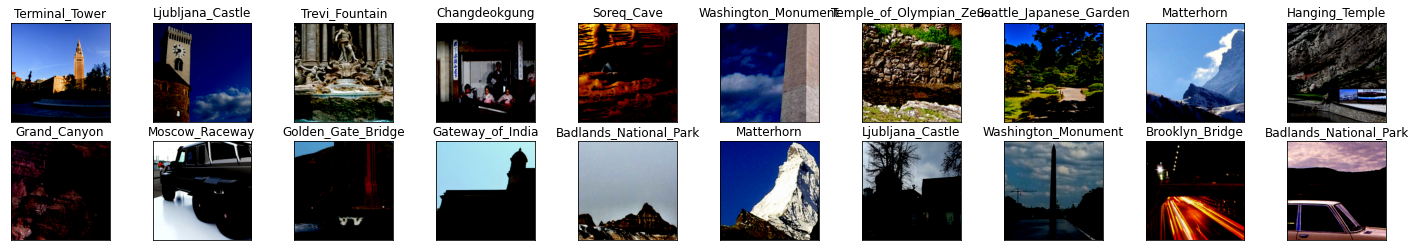

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

#print(train_data.classes)
classes = [classes_name.split(".")[1] for classes_name in train_data.classes]
print(classes[48]) 

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])


### Initialize use_cuda variable

In [6]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [7]:
import torch.optim as optim
import torch.nn as nn
import torch

In [8]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.SGD(model.parameters(), lr=0.01)
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*32*32, 256)
        self.fc2 = nn.Linear(256, 50)
        self.dropout = nn.Dropout(0.3)
        
        ## Define layers of a CNN

        
        
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x))) # size 128
        x = self.pool(F.relu(self.conv2(x))) # size 64
        x = self.pool(F.relu(self.conv3(x))) # size 32
        x = x.view(-1, 64 * 32 * 32 )
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
model_scratch

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

I took the architeture using three convolutional layers with increasing filter to pick up distinct patterns. I also added pooling layer between each layer to increase the training efficiency of the model we are building and dropout layer to minimize the risk of overfitting. Also I added the flattened layer to reduce any noise since we are dealing with images and they may have alot of noises.




### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [10]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx +1))*(loss.data.item() - valid_loss))
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [11]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for the two linear layers
    if classname.find('Linear') != -1:
        num_inputs = m.in_features
        y = 1.0/np.sqrt(num_inputs)
        m.weight.data.uniform_(-y,y)
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.907905 	Validation Loss: 3.900589
Epoch: 2 	Training Loss: 3.875182 	Validation Loss: 3.852539
Epoch: 3 	Training Loss: 3.809585 	Validation Loss: 3.776310
Epoch: 4 	Training Loss: 3.728892 	Validation Loss: 3.702691
Epoch: 5 	Training Loss: 3.646064 	Validation Loss: 3.649485
Epoch: 6 	Training Loss: 3.617256 	Validation Loss: 3.614871
Epoch: 7 	Training Loss: 3.566411 	Validation Loss: 3.550947
Epoch: 8 	Training Loss: 3.519295 	Validation Loss: 3.540489
Epoch: 9 	Training Loss: 3.495293 	Validation Loss: 3.527622
Epoch: 10 	Training Loss: 3.464428 	Validation Loss: 3.474404
Epoch: 11 	Training Loss: 3.412589 	Validation Loss: 3.444912
Epoch: 12 	Training Loss: 3.369523 	Validation Loss: 3.393666
Epoch: 13 	Training Loss: 3.332897 	Validation Loss: 3.397261
Epoch: 14 	Training Loss: 3.297572 	Validation Loss: 3.327685
Epoch: 15 	Training Loss: 3.270470 	Validation Loss: 3.251888
Epoch: 16 	Training Loss: 3.227941 	Validation Loss: 3.331976
Epoch: 17 	Traini

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [12]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.907016 	Validation Loss: 3.893446
Epoch: 2 	Training Loss: 3.862500 	Validation Loss: 3.833620
Epoch: 3 	Training Loss: 3.792341 	Validation Loss: 3.772055
Epoch: 4 	Training Loss: 3.747087 	Validation Loss: 3.694273
Epoch: 5 	Training Loss: 3.667614 	Validation Loss: 3.652763
Epoch: 6 	Training Loss: 3.619894 	Validation Loss: 3.653145
Epoch: 7 	Training Loss: 3.575944 	Validation Loss: 3.560502
Epoch: 8 	Training Loss: 3.534971 	Validation Loss: 3.544501
Epoch: 9 	Training Loss: 3.507259 	Validation Loss: 3.529465
Epoch: 10 	Training Loss: 3.462248 	Validation Loss: 3.499409
Epoch: 11 	Training Loss: 3.436768 	Validation Loss: 3.476321
Epoch: 12 	Training Loss: 3.421060 	Validation Loss: 3.423833
Epoch: 13 	Training Loss: 3.370701 	Validation Loss: 3.419727
Epoch: 14 	Training Loss: 3.317807 	Validation Loss: 3.357537
Epoch: 15 	Training Loss: 3.333859 	Validation Loss: 3.370931
Epoch: 16 	Training Loss: 3.279856 	Validation Loss: 3.320826
Epoch: 17 	Traini

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [13]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.601529


Test Accuracy: 35% (446/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [14]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
data_dir = 'landmark_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# transform
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

# define dataloader parameters
batch_size = 20
num_workers=0
valid_size = 0.2


num_train = len(train_data)
indices = list(range(num_train)) 
np.random.shuffle(indices) 
split = int(np.floor(valid_size * num_train)) 
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=train_sampler, num_workers=0)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=valid_sampler, num_workers=0)
test_loader =  torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=0)

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

#print(train_data.classes)
classes = [classes_name.split(".")[1] for classes_name in train_data.classes]
print(classes[48]) 



Num training images:  4996
Num test images:  1250
Whitby_Abbey


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [15]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.SGD(model.classifier.parameters(), lr=0.01)
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [16]:
## TODO: Specify model architecture

model_transfer = models.vgg16(pretrained=True)

#freezing features- weights
for param in model_transfer.features.parameters():
    param.require_grad =False
    
# replace last layer    
model_transfer.classifier[6] = nn.Linear( model_transfer.classifier[6].in_features , len(classes) )

print(model_transfer)


#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

I used the VGG16 network architecture. The network has 16 layers of depth and can classify images into 1000 categories. VGG16 has 16 trained convolutional layers with a fixed $3\times 3$ filter size; the number of filters progressively increasing from 16 to 512. Each convolutional layer is passed through a ReLU activation with a total of 5 max pooling of size $2\times 2$ filters intermittently applied. The result is then passed to 3 linear fully connected layers, with ReLU activation and dropout applied. I think the architecture is suitable for this current problem because the architeture is suitable for small size CNN problems which our project falls under. Our model outputs 50 classes as regards to the landmark images.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [17]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
num_epochs = 20

model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
                      criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.725075 	Validation Loss: 2.007002
Epoch: 2 	Training Loss: 1.908397 	Validation Loss: 1.736769
Epoch: 3 	Training Loss: 1.680253 	Validation Loss: 1.691668
Epoch: 4 	Training Loss: 1.522241 	Validation Loss: 1.600580
Epoch: 5 	Training Loss: 1.445217 	Validation Loss: 1.553792
Epoch: 6 	Training Loss: 1.332206 	Validation Loss: 1.491082
Epoch: 7 	Training Loss: 1.249633 	Validation Loss: 1.420124
Epoch: 8 	Training Loss: 1.217926 	Validation Loss: 1.492720
Epoch: 9 	Training Loss: 1.161922 	Validation Loss: 1.467328
Epoch: 10 	Training Loss: 1.097399 	Validation Loss: 1.415828
Epoch: 11 	Training Loss: 1.047576 	Validation Loss: 1.443556
Epoch: 12 	Training Loss: 1.019952 	Validation Loss: 1.388769
Epoch: 13 	Training Loss: 0.964924 	Validation Loss: 1.384440
Epoch: 14 	Training Loss: 0.940454 	Validation Loss: 1.383502
Epoch: 15 	Training Loss: 0.929556 	Validation Loss: 1.357001
Epoch: 16 	Training Loss: 0.888881 	Validation Loss: 1.378094
Epoch: 17 	Traini

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [18]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.129439


Test Accuracy: 70% (876/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [19]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    image = Image.open(img_path)
    
    transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.ToTensor()])
                                    
    image= transform(image)
    image.unsqueeze_(0)
  
    if use_cuda:
        image = image.cuda()
        
    model_transfer.eval()  
                                    
    output = model_transfer(image)
    values, indices = output.topk(k)
    
    top_k_classes = []
    
    for i in indices[0].tolist():
        top_k_classes.append(classes[i])

    model_transfer.train()
    
    return top_k_classes


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Dead_Sea',
 'Yellowstone_National_Park',
 'Grand_Canyon',
 'Machu_Picchu',
 'Mount_Rainier_National_Park']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

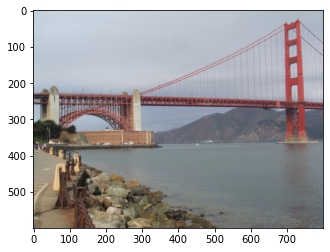

Is this picture of the Golden_Gate_Bridge , Forth_Bridge , or Brooklyn_Bridge


In [20]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    print('Is this picture of the',predicted_landmarks[0],',', predicted_landmarks[1],', or', predicted_landmarks[2])
    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

* The model did pretty well in predicting the close locations of the landmark images gotten randomly from the internet.
* A possible improvement I would suggest would be in tunning the parameters of the model, this may improve the model.
* Another point of improvement is to includes more categories of landmark images in the training and testing set.
* Another point of improvement is to train the model on more classifier layers.

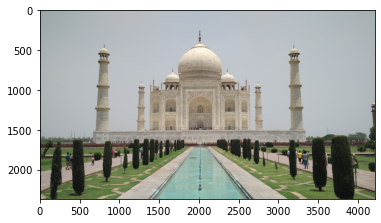

Is this picture of the Gateway_of_India , Taj_Mahal , or Vienna_City_Hall


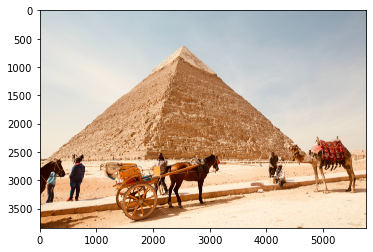

Is this picture of the Grand_Canyon , Dead_Sea , or Death_Valley_National_Park


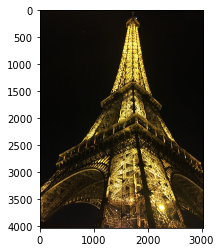

Is this picture of the Eiffel_Tower , Matterhorn , or Whitby_Abbey


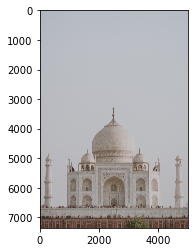

Is this picture of the Kantanagar_Temple , Monumento_a_la_Revolucion , or Vienna_City_Hall


In [24]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('landmark_images/sourabh-nilakhe-sYrTr4w42Pk-unsplash.jpg')
suggest_locations('landmark_images/fynn-schmidt-hKwWA1nNKt4-unsplash.jpg')
suggest_locations('landmark_images/gabriela-molina-VhsJvRiVwX8-unsplash.jpg')
suggest_locations('landmark_images/annie-spratt-75gcu08p9TY-unsplash.jpg')